In [0]:
#@title Input

api_key = '' #@param {type:"string"}
property = 'band_gap' #@param {type:"string"}

In [2]:
! pip install matminer

    100% |████████████████████████████████| 8.4MB 816kB/s 
    100% |████████████████████████████████| 1.8MB 15.8MB/s 
    100% |████████████████████████████████| 409kB 23.9MB/s 
    100% |████████████████████████████████| 163kB 29.4MB/s 
    100% |████████████████████████████████| 40kB 16.9MB/s 
    100% |████████████████████████████████| 37.0MB 901kB/s 
    100% |████████████████████████████████| 655kB 19.1MB/s 
    100% |████████████████████████████████| 61kB 21.8MB/s 
    100% |████████████████████████████████| 31.2MB 1.6MB/s 
    100% |████████████████████████████████| 51kB 18.5MB/s 
    100% |████████████████████████████████| 245kB 26.9MB/s 
    100% |████████████████████████████████| 81kB 25.0MB/s 
    100% |████████████████████████████████| 61kB 16.1MB/s 
    100% |████████████████████████████████| 2.1MB 11.1MB/s 
    100% |████████████████████████████████| 430kB 23.0MB/s 
    100% |████████████████████████████████| 102kB 28.2MB/s 
    100% |████████████████████████████████| 25

In [0]:
import numpy as np 
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline  
from sklearn import decomposition
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [0]:

from matminer.data_retrieval.retrieve_MP import MPDataRetrieval

from pymatgen import MPRester
from pymatgen.core.composition import Composition
from pymatgen.core.molecular_orbitals import MolecularOrbitals
from pymatgen.core.periodic_table import get_el_sp
from pymatgen.core import periodic_table

mpdr = MPDataRetrieval(api_key)

In [0]:
def get_atom_feats(pretty_formula):
  '''get atomic features'''

  comp = Composition(pretty_formula)
  elem,fracs = zip(*comp.fractional_composition.items())

  v = []

  # 0. average row in the periodic table
  v.append(sum([el.row*fr for (el,fr) in zip(elem,fracs)]))
  
  # 1. average column in the periodic table
  v.append(sum([el.group*fr for (el,fr) in zip(elem,fracs)]))

  # 2. average atomic number
  v.append(sum([el.number*fr for (el,fr) in zip(elem,fracs)]))

  # 3. average electronegativity
  v.append(sum([el.X*fr for (el,fr) in zip(elem,fracs)]))
    
  # 4. average atomic mass
  v.append(sum([el.data['Atomic mass']*fr for (el,fr) in zip(elem,fracs)]))

#   # 5. average atomic radius
#   v.append(sum([el.data['Atomic radius']*fr for (el,fr) in zip(elem,fracs)]))

   
  # ------------------------------------------------------------------------
  
  # 5. average ionic radius
  v.append(sum([el.average_ionic_radius*fr for (el,fr) in zip(elem,fracs)]))

  # 6. average max oxidation state
  v.append(sum([el.max_oxidation_state*fr for (el,fr) in zip(elem,fracs)]))

  # 7. average min oxidation state
  v.append(sum([el.min_oxidation_state*fr for (el,fr) in zip(elem,fracs)]))

  return v

In [0]:
def encode_chem(pretty_formula):
  '''encode chemistry'''
  
  comp = Composition(pretty_formula).fractional_composition
  
  pt = periodic_table
  elem_list = dir(pt.Element)
  a = [s for s in elem_list if "_" not in s]
  v = [0.0]*len(a)
  
  elements = comp.elements
  
  for el in elements:
    v[elem_list.index(el.name)] = comp[el]

  return v

In [0]:
def get_crys_feats(mp_id):
  
  v = []    
  v.append(crys_data.loc[mp_id]['initial_structure']['lattice']['a'])
  v.append(crys_data.loc[mp_id]['initial_structure']['lattice']['b'])
  v.append(crys_data.loc[mp_id]['initial_structure']['lattice']['c'])
  
  v.append(crys_data.loc[mp_id]['initial_structure']['lattice']['volume'])
  
  return v

In [0]:
def get_crys_feats_new(mp_id):
  
  crys_data = mpdr.get_dataframe({"material_id": mp_id}, ['pretty_formula','initial_structure'])  
  
  v = []    
  v.append(crys_data.loc[mp_id]['initial_structure']['lattice']['a'])
  v.append(crys_data.loc[mp_id]['initial_structure']['lattice']['b'])
  v.append(crys_data.loc[mp_id]['initial_structure']['lattice']['c'])
  
  v.append(crys_data.loc[mp_id]['initial_structure']['lattice']['volume'])
  
  return v

In [9]:
# # All entries with BG > 0.5
# thr = 0.5
# data_bg = mpdr.get_dataframe({"band_gap": {"$gt": thr}}, ['pretty_formula','band_gap'])
# print("There are {} entries on MP with a band gap larger than {}".format(data_bg['band_gap'].count(),thr))

# Li Fe O system
thr = 0.1
prop = "band_gap"
prop_data = mpdr.get_dataframe(criteria={
                                       "elements": {"$all": ["Li", "Fe", "O"]},
                                       prop: {"$exists": True},
                                        "e_above_hull": {"$lt": 0.5},
                                       ("{}.warnings".format(prop)): None,
                                       prop: {"$gt": thr}}, 
                             properties=['pretty_formula',prop])
print("There are {} entries on MP with Li Fe O elements".format(prop_data[prop].count()))

y = prop_data[prop].values

There are 1758 entries on MP with Li Fe O elements


In [0]:
# Load crystal structures

# initialize dataframe
crys_data = pd.DataFrame(columns=['pretty_formula','initial_structure'])

# lists of mp ids
chunk_size = 1000
mp_ids = prop_data.index.tolist()
sublists = [mp_ids[i:i+chunk_size] for i in range(0, len(mp_ids), chunk_size)]

# query structures from mp
for sublist in sublists:
  crys_data = crys_data.append(mpdr.get_dataframe({"material_id":{"$in": sublist}}, ['pretty_formula','initial_structure']))
  
# # test features
# v1 = get_atom_feats('FeO')
# print(len(v1))
# v2 = encode_chem('FeO')
# print(len(v2))
# v3 = get_crys_feats(mp_ids[0])
# print(len(v3))

In [14]:
# Get features
x = np.zeros((len(y),115))

c = 0
for index, row in prop_data.iterrows():

  comp = row['pretty_formula']
  
  v1 = get_atom_feats(comp)
  v2 = encode_chem(comp)
  v3 = get_crys_feats(index)
  
  x[c,:] = v1+v2+v3
  c += 1
  if c % 1000 == 0:
    print('Done with ', c)

# replace nans with zeros
x = np.nan_to_num(x)

Done with  1000


In [0]:
# Split data into test and train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=42)

In [16]:
# Polynomial regression 

max_deg = 2

property_linker = LinearRegression()
linker = Pipeline([('poly', PolynomialFeatures(degree=max_deg)),('connector', property_linker)])
linker.fit(x_train, y_train)

y_hat_train = linker.predict(x_train)
y_hat_test  = linker.predict(x_test)

mae_test = np.mean(abs(y_hat_test-y_test))/np.mean(y_test)
print(mae_test)

mae_train = np.mean(abs(y_hat_train-y_train))/np.mean(y_train)
print(mae_train)

# plt.scatter(y_train, y_hat_train, c="blue")
# plt.scatter(y_test, y_hat_test, c="red")
# plt.axis('equal')

115.35246714491737
0.14841721023096335


Train error: 0.057 
Test error : 0.154 


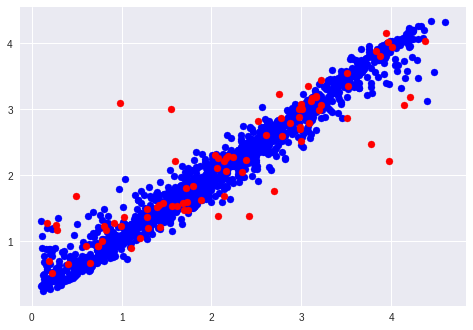

In [19]:
# Random Forest

rf = RandomForestRegressor(n_estimators=50,
                           oob_score=True, random_state=42, verbose=0)

rf.fit(x_train,y_train)

y_hat_train = rf.predict(x_train) 
y_hat_test = rf.predict(x_test) 

mae_train = np.mean(abs(y_hat_train-y_train))/np.mean(y_train)
print('Train error: %.3f ' % mae_train)

mae_test = np.mean(abs(y_hat_test-y_test))/np.mean(y_test)
print('Test error : %.3f ' % mae_test)

plt.scatter(y_train, y_hat_train, c="blue")
plt.scatter(y_test, y_hat_test, c="red")

In [20]:
imp = rf.feature_importances_

idx = imp>=5.e-2
np.count_nonzero(idx)
ind = np.nonzero(idx)
ind

(array([ 0,  3,  4,  5, 38, 72]),)